In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize
#import tensorflow as tf

In [2]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [3]:
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_test = df.copy()

In [4]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [5]:
df.shape

(12684, 26)

# 1.EDA

## To find the insight of the null value of column car

In [6]:
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

# we can see that 99.15% of the feature 'car' is empty, then we decide to delete this feature.


In [7]:
df_clean = df.copy()

In [8]:
df_clean.loc[df['car'].notnull(),'car']

1237                      Scooter and motorcycle
1238                      Scooter and motorcycle
1239                      Scooter and motorcycle
1240                      Scooter and motorcycle
1241                      Scooter and motorcycle
                          ...                   
8293    Car that is too old to install Onstar :D
8294    Car that is too old to install Onstar :D
8295    Car that is too old to install Onstar :D
8296    Car that is too old to install Onstar :D
8297    Car that is too old to install Onstar :D
Name: car, Length: 108, dtype: object

In [9]:
df_clean.drop(columns = 'car',inplace = True)
df_clean.drop(columns = 'direction_opp',inplace = True)

In [10]:
#df_clean=df_clean.fillna(method='ffill',axis=0).fillna('1~3')
for x in df_clean.columns[df_clean.isna().any()]:
    df_clean = df_clean.fillna({x: df_clean[x].value_counts().idxmax()})

In [11]:
df_clean.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

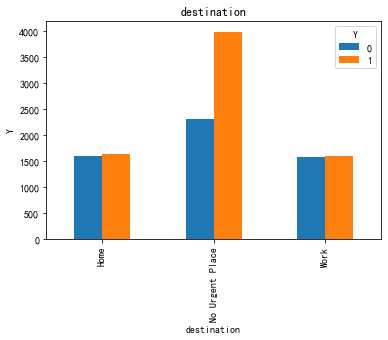

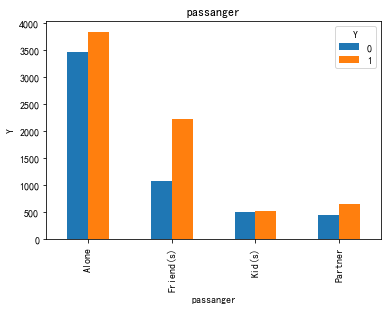

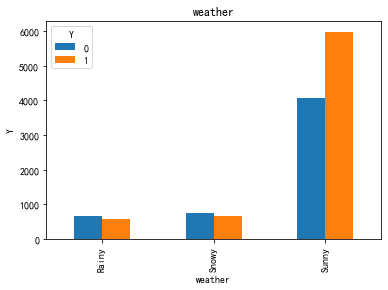

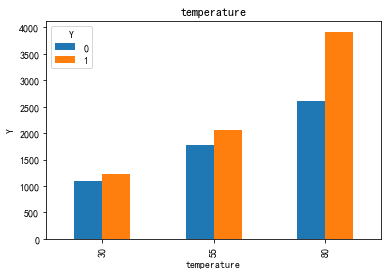

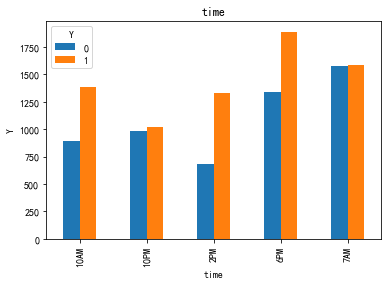

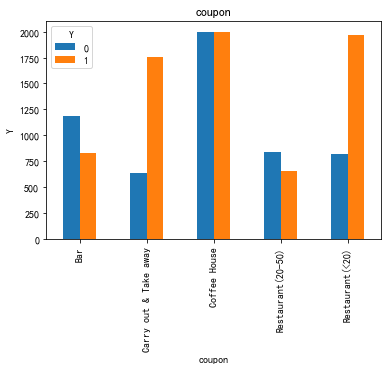

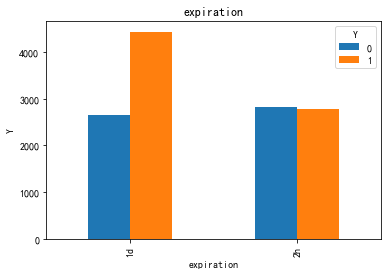

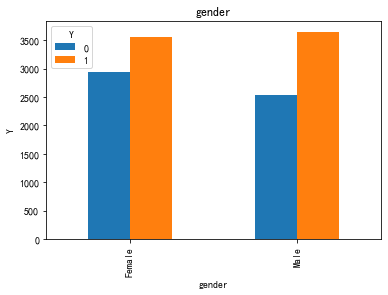

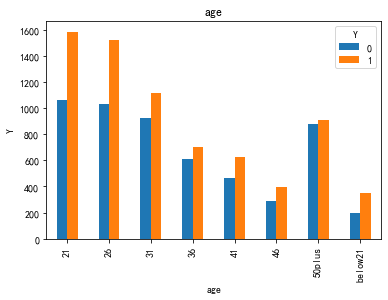

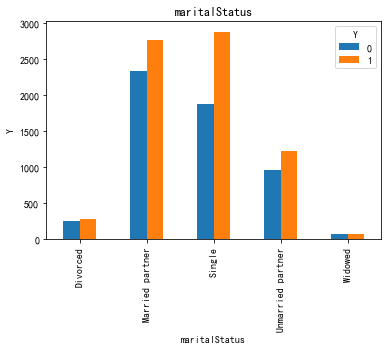

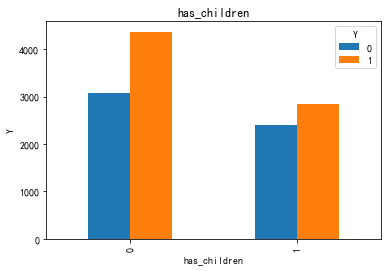

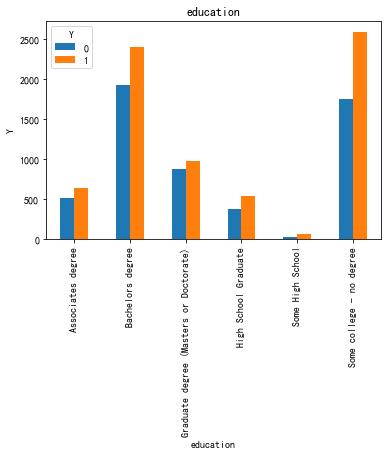

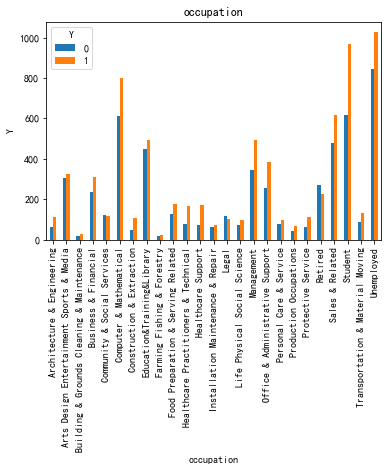

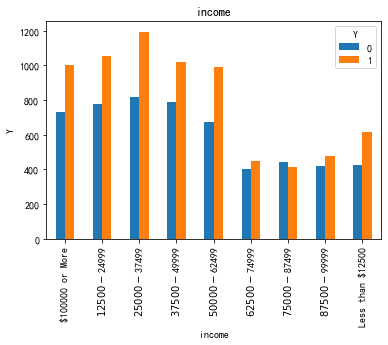

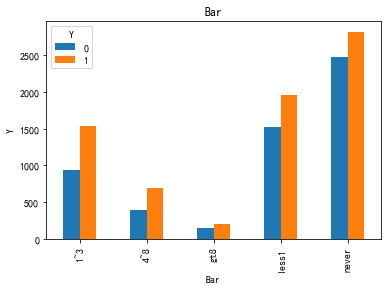

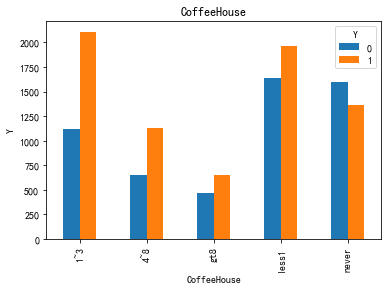

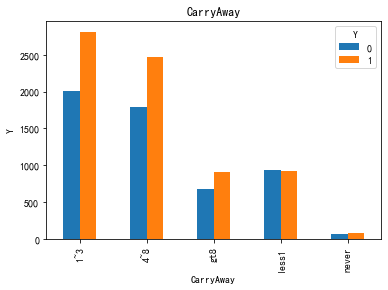

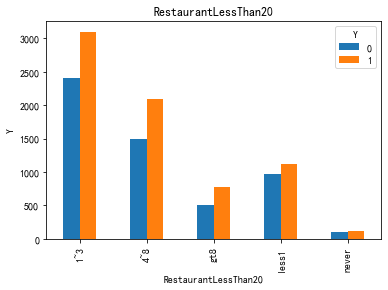

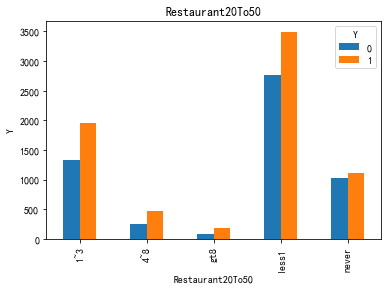

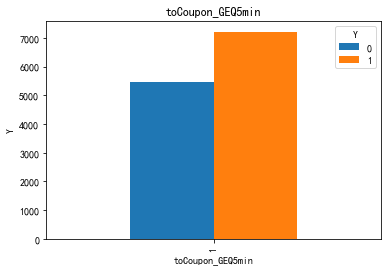

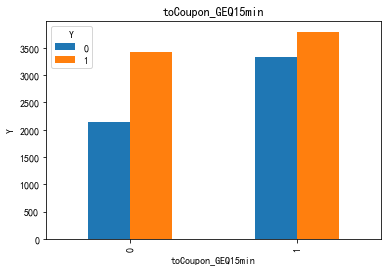

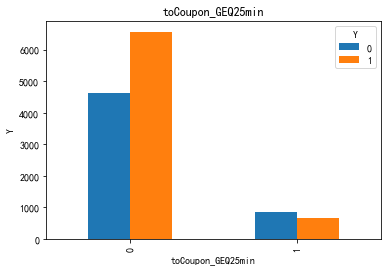

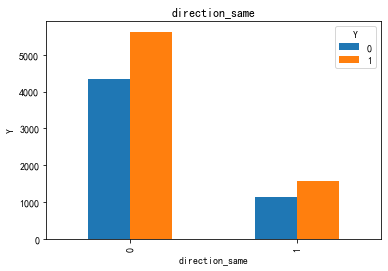

In [12]:
for col in df_clean.drop('Y', axis=1).columns:
    pd.crosstab(df_clean[col], df_clean['Y']).plot(kind='bar')
    plt.title(col)
    plt.ylabel('Y')
    plt.show()

## Because the feature'toCoupon_GEQ5min' has a mean 1 and std is 0 which means all the value is 1, we decide to delete this feature.

In [13]:
df_clean.drop(columns = 'toCoupon_GEQ5min',inplace = True)

## Also the direction_opp column has the same meaning of direction_same

In [14]:
df_clean.describe()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
count,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,0.561495,0.119126,0.214759,0.568433
std,19.154486,0.492593,0.496224,0.323950,0.410671,0.495314
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,80.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
print("Displaying the unique variable of each columns:")
for i in df_clean.columns:
    print(i,df_clean[i].nunique())

Displaying the unique variable of each columns:
destination 3
passanger 4
weather 3
temperature 3
time 5
coupon 5
expiration 2
gender 2
age 8
maritalStatus 5
has_children 2
education 6
occupation 25
income 9
Bar 5
CoffeeHouse 5
CarryAway 5
RestaurantLessThan20 5
Restaurant20To50 5
toCoupon_GEQ15min 2
toCoupon_GEQ25min 2
direction_same 2
Y 2


In [16]:
print('Encoding column expiration with 24hours and 2 hours')
df_clean['expiration'] = np.where(df_clean.expiration =='1d',1,0)

Encoding column expiration with 24hours and 2 hours


In [17]:
print('Encoding column gender with 1 for male and 0 for female')
df_clean.gender = np.where(df_clean.gender =='Male',1,0)

Encoding column gender with 1 for male and 0 for female


In [18]:
df_clean.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1,0,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,0,0,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,0,0,0,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,0,0,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,0,0,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1,0,21,Unmarried partner,...,$37500 - $49999,never,never,1~3,4~8,1~3,1,0,0,0


In [19]:
df_clean.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
Y                       0
dtype: int64

In [20]:
def catboost_target_encoder(train, cols_encode, target):
    train_new = train.copy()
    for column in cols_encode:
        global_mean = train[target].mean()
        cumulative_sum = train.groupby(column)[target].cumsum() - train[target]
        cumulative_count = train.groupby(column).cumcount()
        train_new[column] = cumulative_sum/cumulative_count
        train_new[column].fillna(global_mean, inplace=True)
    return train_new.drop(target, axis = 1)

In [21]:
def onehot_encoder(train, cols_encode):
    train_new = pd.get_dummies(train, prefix_sep='_', columns=cols_encode)
    return train_new

In [22]:
def splitTotrainTest(X, y, test_size = 0.2, random_state = 0):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = test_size, random_state = random_state)
        return  X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = splitTotrainTest(df_clean.drop("Y",axis = 1), df_clean["Y"])
X_columns = list(df_clean.drop("Y",axis =1).columns)

In [24]:
# Choose smaller training sample for SVM due to optimizer running time
# Replace y (0,1) to y(-1, 1) as target variables
X_train_svm, X_test_svm, y_train_svm, y_test_svm = splitTotrainTest(df_clean.drop("Y",axis = 1), 2*df_clean["Y"]-1, test_size = 0.9, random_state = 0)

In [25]:
# Onehot Encoding
X_onehot = onehot_encoder(df_clean.drop("Y", axis = 1), X_columns)
X_train_onehot, X_test_onehot, y_train, t_test = splitTotrainTest(X_onehot, df_clean["Y"])
#SVM sample
X_train_onehot_svm, X_test_onehot_svm, y_train_svm, y_test_svm = splitTotrainTest(X_onehot, 2*df_clean["Y"]-1, test_size = 0.9, random_state = 0)

In [26]:
# Catboost Encoding
X_train_cat = catboost_target_encoder(pd.concat([X_train, y_train], axis=1), X_columns, "Y")
X_test_cat = catboost_target_encoder(pd.concat([X_test, y_test], axis=1), X_columns, "Y")
# SVM sample
X_train_cat_svm = catboost_target_encoder(pd.concat([X_train_svm, y_train_svm], axis=1), X_columns, "Y")
X_test_cat_svm = catboost_target_encoder(pd.concat([X_test_svm, y_test_svm], axis=1), X_columns, "Y")

In [27]:
X_train_cat.describe()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same
count,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,...,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000,10147.000000
mean,0.556043,0.556196,0.557234,0.556893,0.556500,0.556020,0.554882,0.556072,0.556513,0.555927,...,0.556013,0.555103,0.556180,0.556189,0.556525,0.555906,0.556337,0.555936,0.556983,0.556114
std,0.072947,0.071890,0.054871,0.041646,0.060692,0.133174,0.064040,0.028896,0.051702,0.041090,...,0.072947,0.055218,0.052465,0.078129,0.031560,0.039896,0.043145,0.046962,0.054189,0.019064
min,0.000000,0.000000,0.000000,0.406250,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
25%,0.490891,0.508089,0.568449,0.522193,0.500436,0.438708,0.492045,0.532478,0.525862,0.533727,...,0.526473,0.534296,0.523360,0.510365,0.547459,0.548710,0.541806,0.515888,0.564251,0.547792
50%,0.530806,0.519734,0.576366,0.578495,0.555556,0.500415,0.585956,0.544521,0.557549,0.547265,...,0.556999,0.559682,0.534450,0.540492,0.560557,0.559930,0.558180,0.529569,0.572404,0.555738
75%,0.628117,0.644468,0.591947,0.590836,0.599173,0.699322,0.611251,0.580446,0.595601,0.589388,...,0.588235,0.586572,0.608882,0.630301,0.574047,0.572806,0.581927,0.604923,0.585977,0.564550
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
X_test_cat.describe()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same
count,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,...,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000,2537.000000
mean,0.559187,0.558911,0.559319,0.559783,0.559621,0.561128,0.559679,0.559963,0.557874,0.559317,...,0.557455,0.561383,0.557739,0.555266,0.560363,0.558967,0.558724,0.560284,0.560243,0.558861
std,0.078588,0.073122,0.084434,0.050435,0.086436,0.125777,0.072978,0.038504,0.056288,0.051927,...,0.117069,0.066759,0.068332,0.093095,0.071902,0.064001,0.062467,0.051890,0.049863,0.034951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.496124,0.519008,0.582090,0.536785,0.496753,0.461929,0.496377,0.547695,0.527660,0.538559,...,0.504274,0.525000,0.517615,0.500000,0.552381,0.547901,0.526989,0.532609,0.569124,0.560288
50%,0.527950,0.528073,0.595879,0.570093,0.558824,0.519713,0.609907,0.565495,0.570397,0.552083,...,0.560510,0.567901,0.561644,0.583333,0.570652,0.554869,0.538547,0.537750,0.578917,0.562868
75%,0.628055,0.629630,0.601707,0.590535,0.634483,0.689873,0.616637,0.577049,0.588123,0.595588,...,0.602804,0.594203,0.604418,0.619469,0.603947,0.573964,0.610915,0.602763,0.582845,0.569024
max,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.692308


In [29]:
X_train_onehot.tail()

,destination_Home,destination_No Urgent Place,destination_Work,passanger_Alone,passanger_Friend(s),passanger_Kid(s),passanger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,...,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,toCoupon_GEQ15min_0,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,toCoupon_GEQ25min_1,direction_same_0,direction_same_1
4859,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,0,1
3264,1,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
9845,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
10799,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,0,1,1,0,1,0
2732,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0


In [30]:
X_train_cat.tail()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same
4859,0.505401,0.526858,0.594642,0.602667,0.587124,0.500627,0.628622,0.594540,0.633867,0.605822,...,0.617225,0.521021,0.535063,0.658301,0.587288,0.566614,0.562401,0.619187,0.589172,0.586906
3264,0.505592,0.526939,0.594692,0.535609,0.587283,0.443709,0.628688,0.546662,0.599433,0.545186,...,0.560861,0.597006,0.535172,0.542520,0.578566,0.533293,0.562488,0.531541,0.589218,0.565408
9845,0.505783,0.527020,0.476693,0.533875,0.512531,0.709792,0.495984,0.546749,0.506241,0.545298,...,0.557847,0.603116,0.627823,0.634764,0.508784,0.566712,0.562574,0.531623,0.429975,0.565463
10799,0.636509,0.672968,0.594742,0.602742,0.512210,0.408663,0.628753,0.546644,0.548936,0.605926,...,0.457627,0.481426,0.583039,0.634318,0.587408,0.584899,0.654822,0.531530,0.589264,0.565392
2732,0.504344,0.526930,0.594668,0.535761,0.504344,0.709477,0.628642,0.594622,0.599622,0.605767,...,0.558036,0.536960,0.627501,0.658433,0.578675,0.584696,0.593240,0.619272,0.589198,0.565321


In [31]:
X_train_onehot.shape

(10147, 113)

In [32]:
X_train_cat_svm.shape

(1268, 22)

In [33]:
y_train_svm.value_counts()

 1    755
-1    513
Name: Y, dtype: int64

# Modelling

## Logistic Regression

In [34]:
class LogisticRegression():
    def __init__(self, X_train, y_train, X_test, y_test, learningRate,tolerance,maxIteration, reg = False, reglambda = 1, regtype = 'Lasso'):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.reg = reg
        self.reglambda = reglambda
        self.regtype = regtype
    
    def normalize(self,X):
        mean = np.mean(X,0)
        std = np.std(X,0)
        X_norm = (X - mean)/std
        #X_norm = self.addX0(X_norm)
        return X_norm, mean, std
    
    def normalizeTestData(self,X,train_mean,train_std):
        X_norm = (X - train_mean)/train_std
        #X_norm = self.addX0(X_norm)
        return X_norm
    
    def addX0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]),X])
    
    def sigmoid(self,z):
        sig = 1/(1+np.exp(-z))
        return sig
    
    def costFunction(self,X,y):
        pred_ = np.log(np.ones(X.shape[0])+np.exp(X.dot(self.w)))-X.dot(self.w).dot(y.T) # Negative log likelihood function
        cost = pred_.sum()
        
        return cost
    
    def gradient(self,X,y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X) #number of gradient is features
        
        return grad
    
    def gradientDescent(self,X,y):
        
        cost_sequence = []
        last_cost = float('inf')
        for i in tqdm(range(self.maxIteration)):
            if self.reg:
                if self.regtype == 'Lasso':
                    self.w = self.w - self.learningRate * self.gradient(X,y) + self.reglambda
                if self.regtype == 'Ridge':
                    self.w = self.w - self.learningRate * self.gradient(X,y) + self.reglambda * self.w
            else:
                self.w = self.w - self.learningRate * self.gradient(X,y)
            
            cur_cost = self.costFunction(X,y)
            diff = last_cost - cur_cost
            last_cost = cur_cost
            cost_sequence.append(cur_cost)
            # add patience for the loop
            if diff<self.tolerance:
                print('The model Stopped - Converged')
                break
        self.plotCost(cost_sequence)
        #print(cost_sequence[-1])
        return
          
    def predict(self,X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
        
    def evaluate(self,y,y_hat):
        accuracy=0
        precision=0
        recall=0
        y = (y==1)
        y_hat = (y_hat ==1)
        accuracy = (y==y_hat).sum()/y.size
        precision = (y & y_hat).sum()/y_hat.sum()
        recall = (y & y_hat).sum()/y.sum()
        return accuracy,precision,recall
    
    def runModel(self):
        print('solving using gradient descent')
        self.w = np.ones(self.X_train.shape[1], dtype = np.float64)*0
        self.gradientDescent(self.X_train, self.y_train)
        
        # No need for standardization because the raw data is already standardized (either onehot encoding or catboost encoding)
        
        #self.X_train, self.mean,self.std = self.normalize(self.X_train)
        #self.X_test = self.normalizeTestData(self.X_test,self.mean,self.std)
        
        y_hat_train = self.predict(self.X_train)
        #print(y_hat_train)
        accuracy,precision,recall = self.evaluate(self.y_train,y_hat_train)
        print('Evaluation for training data:\n')
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        
        y_hat_test = self.predict(self.X_test)
        accuracy,precision,recall = self.evaluate(self.y_test,y_hat_test)
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        print('\n\nEvaluation for test data:\n')
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        
    def Remove(self,num):
        x_train = np.delete(self.X_train,num,0)
        y_train = np.delete(self.y_train,num,0)
        return x_train,y_train
    
    def plotCost(self,error_sequence):
        #s = np.array(error_sequence)
        #t = np.arange(s.size)
        s = range(1,len(error_sequence)+1)
        t = np.array(error_sequence)
        fig,ax = plt.subplots(figsize=(10,8))
        plt.rcParams['axes.unicode_minus']=False
        ax.plot(s,t)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')


  0%|                                                                                | 6/10000 [00:00<03:11, 52.19it/s]

solving using gradient descent


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:22<00:00, 49.50it/s]


Evaluation for training data:

Accuracy: 0.6958707006997142
Precision: 0.713855421686747
Recall: 0.7785269709543569


Evaluation for test data:

Accuracy: 0.6815135987386677
Precision: 0.6955696202531646
Recall: 0.770687237026648


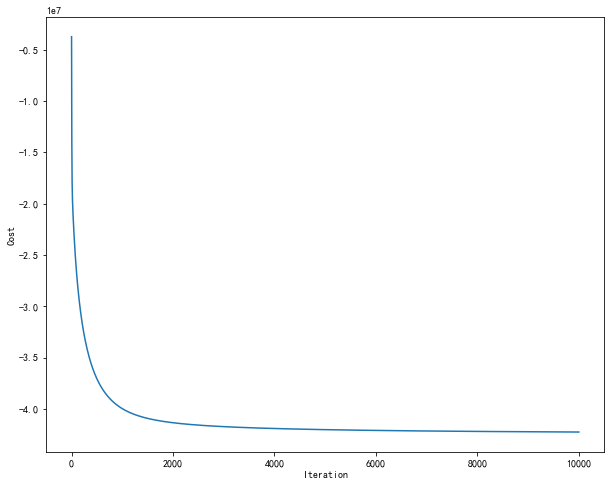

In [35]:
lr = LogisticRegression(X_train_onehot, y_train, X_test_onehot, y_test, learningRate=1e-5, tolerance=0.001, maxIteration=10000)      
lr.runModel()

  0%|                                                                                | 6/10000 [00:00<03:06, 53.72it/s]

solving using gradient descent


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:07<00:00, 53.39it/s]


Evaluation for training data:

Accuracy: 0.6620676061890214
Precision: 0.6786527082385071
Recall: 0.7733402489626556


Evaluation for test data:

Accuracy: 0.637761135199054
Precision: 0.656
Recall: 0.7475455820476858


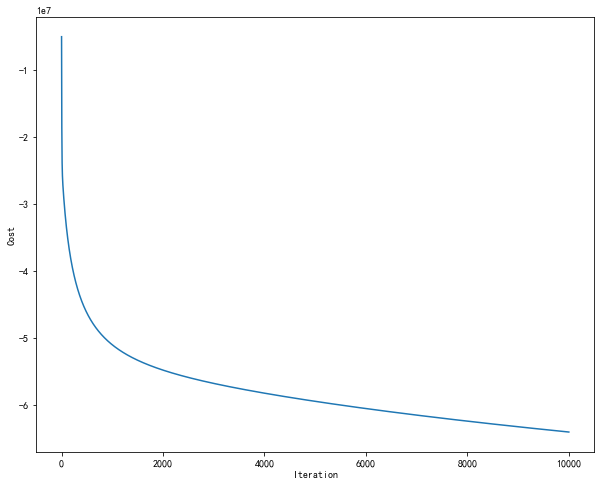

In [36]:
lr_Lasso = LogisticRegression(X_train_onehot, y_train, X_test_onehot, y_test, learningRate=1e-5, tolerance=0.001, maxIteration=10000, 
                              reg = True, reglambda = 0.001, regtype = 'Lasso')      
lr_Lasso.runModel()

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

solving using gradient descent


 83%|████████████████████████████████████████████████████████████████             | 8314/10000 [02:42<00:33, 50.22it/s]D:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 83%|████████████████████████████████████████████████████████████████             | 8315/10000 [02:42<00:32, 51.21it/s]


The model Stopped - Converged
Evaluation for training data:

Accuracy: 0.6510298610426727
Precision: 0.6935957189711721
Recall: 0.6946749654218534


Evaluation for test data:

Accuracy: 0.637761135199054
Precision: 0.6817204301075269
Recall: 0.6669004207573632


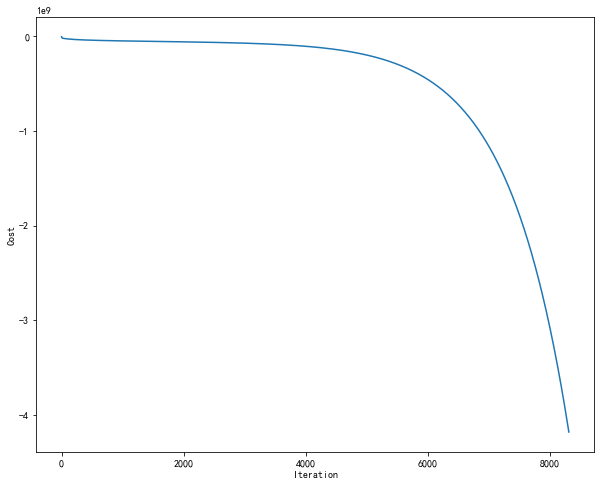

In [37]:
lr_Ridge = LogisticRegression(X_train_onehot, y_train, X_test_onehot, y_test, learningRate=1e-5, tolerance=0.001, maxIteration=10000, 
                              reg = True, reglambda = 0.001, regtype = 'Ridge')      
lr_Ridge.runModel()

solving using gradient descent


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 275.12it/s]


Evaluation for training data:

Accuracy: 0.6532965408495122
Precision: 0.6736664622930717
Recall: 0.7598547717842323


Evaluation for test data:

Accuracy: 0.6424911312573907
Precision: 0.6509598603839442
Recall: 0.7847124824684432


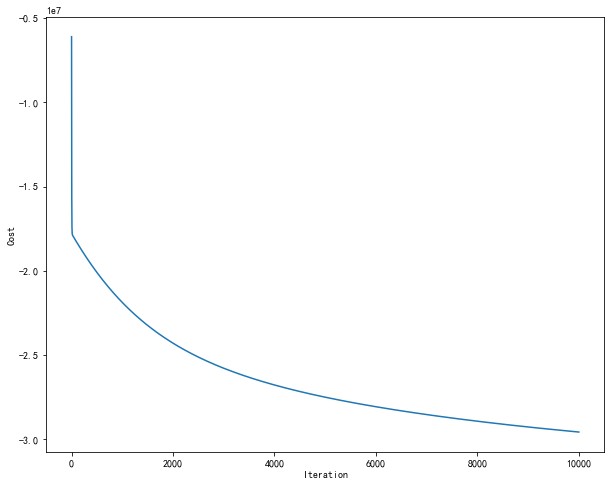

In [38]:
lr_cat = LogisticRegression(X_train_cat, y_train, X_test_cat, y_test, learningRate=2e-5, tolerance=0.001, maxIteration=10000)      
lr_cat.runModel()

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

solving using gradient descent


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.95it/s]


Evaluation for training data:

Accuracy: 0.6441312703262048
Precision: 0.6523629224512691
Recall: 0.8042876901798064


Evaluation for test data:

Accuracy: 0.6298778084351596
Precision: 0.6286318013734813
Recall: 0.8345021037868162


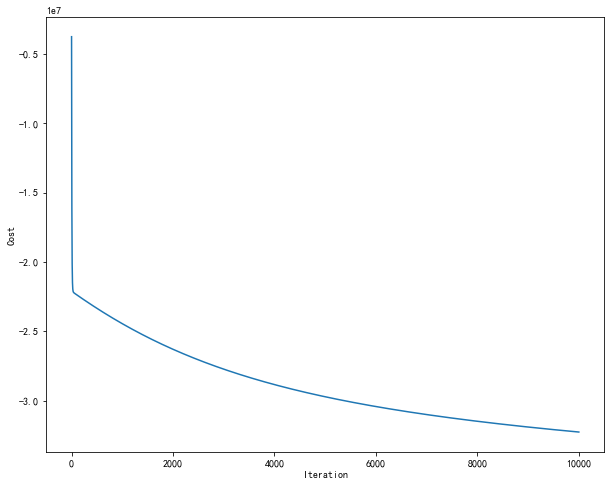

In [39]:
lr_Lasso_cat = LogisticRegression(X_train_cat, y_train, X_test_cat, y_test, learningRate=1e-5, tolerance=0.001, maxIteration=10000, 
                                  reg = True, reglambda = 0.001, regtype = 'Lasso')      
lr_Lasso_cat.runModel()

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

solving using gradient descent


 76%|█████████████████████████████████████████████████████████▊                  | 7612/10000 [00:33<00:09, 246.17it/s]D:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
 77%|██████████████████████████████████████████████████████████▌                 | 7706/10000 [00:33<00:10, 226.68it/s]
D:\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


The model Stopped - Converged
Evaluation for training data:

Accuracy: 0.6538878486252094
Precision: 0.6968121968121969
Recall: 0.6953665283540802


Evaluation for test data:

Accuracy: 0.6472211273157272
Precision: 0.6720674011665586
Recall: 0.7272089761570828


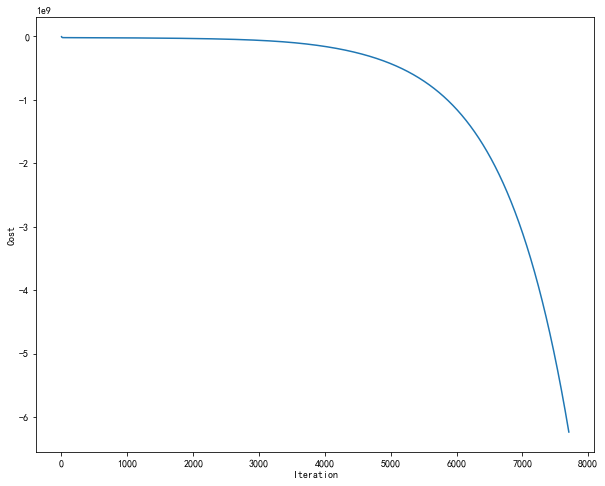

In [40]:
lr_Ridge_cat = LogisticRegression(X_train_cat, y_train, X_test_cat, y_test, learningRate=1e-5, tolerance=0.001, maxIteration=10000, 
                                  reg = True, reglambda = 0.001, regtype = 'Ridge')      
lr_Ridge_cat.runModel()

## Naive Bayes

In [41]:
class NaiveBayes:
    # generative function do not have parameters that we need to set
    def __init__(self, X_train, y_train, X_test, y_test, a):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.a = a
        

    def calc_statistics(self, X, y):
        
        self.mean = X.groupby(y).apply(np.mean).to_numpy()
        self.var = X.groupby(y).apply(np.var).to_numpy()
              
        return self.mean, self.var   
    
    def calc_pdf(self, class_idx, x):
        mu = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mu)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    
    def calc_prior(self, X, y):
        self.prior = (X.groupby(y).apply(lambda x: len(x))/X.shape[0]).to_numpy()
        return self.prior

    # posterior probabilities
    def calc_posterior(self, x):
        posteriors = []
        for i in range(len(np.unique(self.y_train))):
            prior = np.log(self.prior[i])
            conditional = np.sum(np.log(self.calc_pdf(i, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        return np.array([np.argmax(posteriors)])

    
    def runModel(self):

        #Calculate priors and statistics
        self.calc_statistics(self.X_train, self.y_train)
        self.calc_prior(self.X_train, self.y_train)
        
        #Train 
        print('Evaluation for training data:\n')
        y_hat_train = self.predict(self.X_train)
        accuracy,recall,precision = self.evaluate(self.y_train[:,np.newaxis],y_hat_train)
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        
        #Test
        print('Evaluation for test data:\n')
        y_hat_test = self.predict(self.X_test)
        accuracy,recall,precision = self.evaluate(self.y_test[:,np.newaxis],y_hat_test)
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        
    def predict(self, X):
        y_hat = np.array([self.calc_posterior(x) for x in np.array(X)])
        return y_hat
       
        
    def evaluate(self,y,y_hat):
        accuracy=0
        precision=0
        recall=0
        y = (y==1)
        y_hat = (y_hat ==1)
        accuracy = (y==y_hat).sum()/y.size
        precision = (y & y_hat).sum()/y_hat.sum()
        recall = (y & y_hat).sum()/y.sum()
        return accuracy,precision,recall           

In [42]:
nb_onehot = NaiveBayes(X_train_onehot, y_train, X_test_onehot, y_test, 1)
nb_onehot.runModel()

Evaluation for training data:

Accuracy: 0.647974770868237
Precision: 0.6815352697095436
Recall: 0.6949929478138223
Evaluation for test data:

Accuracy: 0.6432794639337801
Precision: 0.6753155680224404
Recall: 0.6854092526690392


In [43]:
nb_cat = NaiveBayes(X_train_cat, y_train, X_test_cat, y_test, 1)
nb_cat.runModel()

Evaluation for training data:

Accuracy: 0.6461022962451957
Precision: 0.7669432918395575
Recall: 0.6641712831262165
Evaluation for test data:

Accuracy: 0.6216003153330706
Precision: 0.8043478260869565
Recall: 0.6274617067833698


## SVM - SoftMargin

In [44]:
class SoftMarginSVM:
    
    def __init__(self, C):
        self.C = C
        self.beta = None
        self.w = None
        self.SupportVectors = None
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = len(X)
        
        Xy = X * y[:,np.newaxis]
        GramXy = np.matmul(Xy, Xy.T) #y_i * y_j * (x_i^T * x_j) within the euation 7.32
        
        def Ld0(G, beta):
            return beta.sum() - 0.5* (beta.dot(beta.dot(G)))
        
        def partialDerivation(G, beta):
            return np.ones_like(beta) - beta.dot(G)
        
        # Constraints on beta
        # equiality ==> y.dot(beta) = 0
        # inequalities ==> we have 2*N constraints 
        # first half beta <= C and second half -beta <= 0
        
        beta = np.ones(n_samples) # initialize beta all to 1
        
        B = np.concatenate((np.zeros(n_samples), self.C * np.ones(n_samples)))
        A = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
        
        constraints = ({'type': 'eq', 'fun': lambda beta_i: np.dot(beta_i, y), 'jac' : lambda beta_i: y}, #beta_i is the beta (lagrangian multiplier)
                       
                       {'type': 'ineq', 'fun': lambda beta_i: B - np.dot(A, beta_i), 'jac' : lambda beta_i: -A} #beta constraints <=C and >=0
                      ) 
         
        # Dual Lagrangian --> it's a maximizer
        
        optres = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                   x0 = beta,
                                   method = 'SLSQP',
                                   jac = lambda a: -partialDerivation(GramXy, a),
                                   constraints = constraints)
        
        self.beta = optres.x
        self.w = np.sum((self.beta[:,np.newaxis] * Xy), axis = 0)
        epsilon = 1e-6
        
        self.supportVectors= X[self.beta > epsilon]
        
        supportLabels = y[self.beta > epsilon]
        
        supportVectorDistance = np.matmul(self.supportVectors, self.w)
        
        minDistance = np.argmin(supportVectorDistance)

        self.intercept = supportLabels[minDistance] - supportVectorDistance[minDistance]
               
        #self.intercept = supportLabels[0] - np.matmul(self.supportVectors[0].T,self.w)
        y_train_predict = self.predict(X)
        accuracy,recall,precision = self.evaluate(y, y_train_predict)
        print('Evaluation for training data:\n')
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        
    def predict(self, X):
        y_hat = 2*(np.matmul(X,self.w)+self.intercept>0)-1
        return y_hat
    
    def evaluate(self,y,y_hat):
        accuracy=0
        precision=0
        recall=0
        y = (y==1)
        y_hat = (y_hat ==1)
        accuracy = (y==y_hat).sum()/y.size
        precision = (y & y_hat).sum()/y_hat.sum()
        recall = (y & y_hat).sum()/y.sum()
        return accuracy,precision,recall
    
    def test(self, X, y):
        
        y_test_predict = self.predict(X)
        accuracy,recall,precision = self.evaluate(y, y_test_predict)
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall
        print('Evaluation for test data:\n')
        print('Accuracy:',accuracy)
        print('Precision:',precision)
        print('Recall:',recall)
        

In [45]:
svm_onehot = SoftMarginSVM(C = 1)
svm_cat = SoftMarginSVM(C = 1)

In [46]:
X_train_onehot_svm.shape

(1268, 113)

In [47]:
X_train_cat_svm.shape

(1268, 22)

In [48]:
y_train_svm.value_counts()

 1    755
-1    513
Name: Y, dtype: int64

In [49]:
%%time
svm_onehot.fit(X_train_onehot_svm, y_train_svm)

Evaluation for training data:

Accuracy: 0.694794952681388
Precision: 0.919205298013245
Recall: 0.6803921568627451
Wall time: 18min 2s


In [50]:
%%time
svm_cat.fit(X_train_cat_svm, y_train_svm)

Evaluation for training data:

Accuracy: 0.6151419558359621
Precision: 0.9721854304635762
Recall: 0.611157368859284
Wall time: 12min 51s


In [51]:
svm_onehot.test(X_test_onehot_svm.to_numpy(), y_test_svm)
svm_cat.test(X_test_cat_svm.to_numpy(), y_test_svm)

Evaluation for test data:

Accuracy: 0.6469866853538893
Precision: 0.9005422153369481
Recall: 0.6317791544397348
Evaluation for test data:

Accuracy: 0.6200070077084793
Precision: 0.9106119287374128
Recall: 0.6098142960888059


In [52]:
y_test_hat_svm_onehot = svm_onehot.predict(X_test_onehot_svm.to_numpy())
pd.crosstab(y_test_svm, y_test_hat_svm_onehot)

col_0,-1,1
Y,,
-1,1573,3388
1,642,5813


In [53]:
y_test_hat_svm_cat = svm_cat.predict(X_test_cat_svm.to_numpy())
pd.crosstab(y_test_svm, y_test_hat_svm_cat)

col_0,-1,1
Y,,
-1,1200,3761
1,577,5878


In [54]:
model_list = {
    'logistic onehot' : lr,
    'logistic onehot lasso' : lr_Lasso,
    'logistic onehot ridge' : lr_Ridge,
    'logistic catboost' : lr_cat,
    'logistic catboost lasso' : lr_Lasso_cat,
    'logistic catboost ridge' : lr_Ridge_cat,
    'Naive Bayes onehot' : nb_onehot,
    'Naive Bayes catboost' : nb_cat,
    'SVM SoftMargin onehot' : svm_onehot,
    'SVM SoftMargin catboost' : svm_cat
    }

X_test_list = {
    'logistic onehot' : X_test_onehot,
    'logistic onehot lasso' : X_test_onehot,
    'logistic onehot ridge' : X_test_onehot,
    'logistic catboost' : X_test_cat,
    'logistic catboost lasso' : X_test_cat,
    'logistic catboost ridge' : X_test_cat,
    'Naive Bayes onehot' : X_test_onehot,
    'Naive Bayes catboost' : X_test_cat,
    'SVM SoftMargin onehot' : X_test_onehot_svm,
    'SVM SoftMargin catboost' : X_test_cat_svm
    }

y_test_list = {
    'logistic onehot' : y_test,
    'logistic onehot lasso' : y_test,
    'logistic onehot ridge' : y_test,
    'logistic catboost' : y_test,
    'logistic catboost lasso' : y_test,
    'logistic catboost ridge' : y_test,
    'Naive Bayes onehot' : y_test,
    'Naive Bayes catboost' : y_test,
    'SVM SoftMargin onehot' : y_test_svm,
    'SVM SoftMargin catboost' : y_test_svm
    }

In [55]:
model_performance = pd.DataFrame(columns = ['accuracy', 'precision', 'recall'], index = model_list.keys())

for model in model_list.keys():
    model_performance['accuracy'].loc[model] = model_list[model].accuracy
    model_performance['precision'].loc[model] = model_list[model].precision
    model_performance['recall'].loc[model] = model_list[model].recall
model_performance

,accuracy,precision,recall
logistic onehot,0.681514,0.69557,0.770687
logistic onehot lasso,0.637761,0.656,0.747546
logistic onehot ridge,0.637761,0.68172,0.6669
logistic catboost,0.642491,0.65096,0.784712
logistic catboost lasso,0.629878,0.628632,0.834502
logistic catboost ridge,0.647221,0.672067,0.727209
Naive Bayes onehot,0.643279,0.675316,0.685409
Naive Bayes catboost,0.6216,0.804348,0.627462
SVM SoftMargin onehot,0.646987,0.900542,0.631779
SVM SoftMargin catboost,0.620007,0.910612,0.609814


In [56]:
# Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def model_Evaluate(model, model_name, X_test, y_test):
   
    # Predict values for Test dataset
    y_pred = model.predict(np.array(X_test))

    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))
   
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix - "+ model_name, fontdict = {'size':18}, pad = 20)

---------------------------------------

logistic onehot
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      1111
           1       0.70      0.77      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.68      0.67      0.67      2537
weighted avg       0.68      0.68      0.68      2537

---------------------------------------

logistic onehot lasso
              precision    recall  f1-score   support

           0       0.61      0.50      0.55      1111
           1       0.66      0.75      0.70      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.62      0.62      2537
weighted avg       0.63      0.64      0.63      2537

---------------------------------------

logistic onehot ridge
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1111
           1       0.68      0.67      0.67      1426


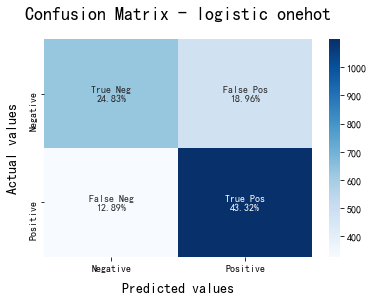

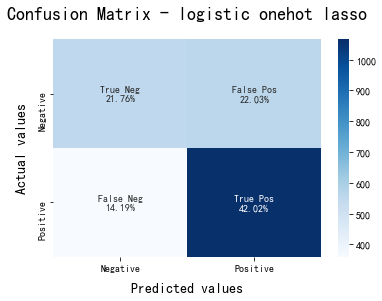

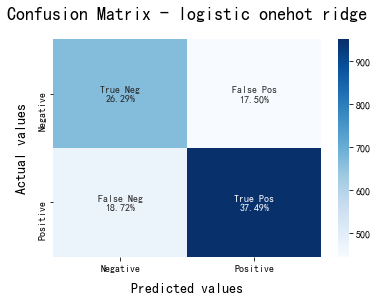

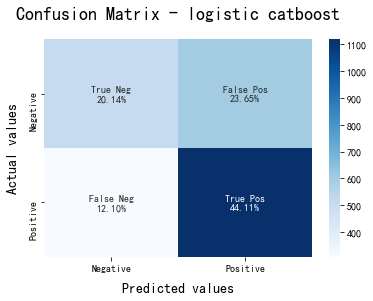

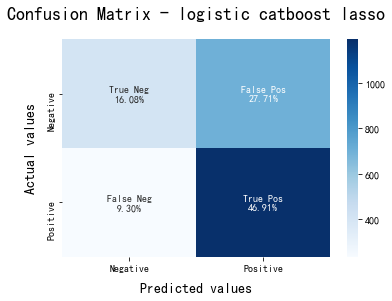

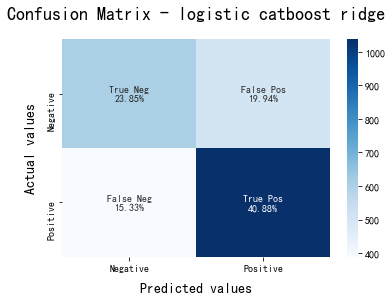

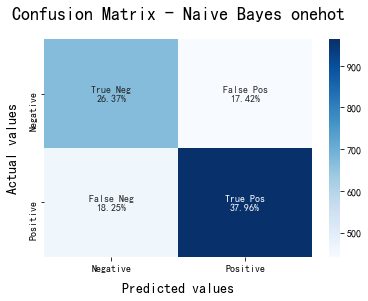

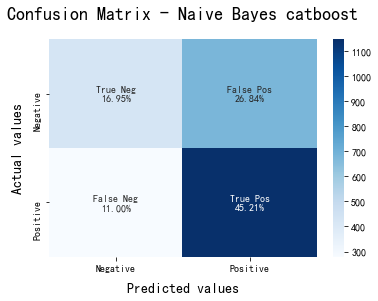

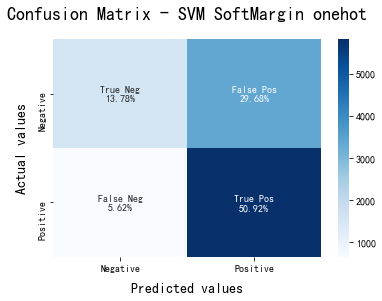

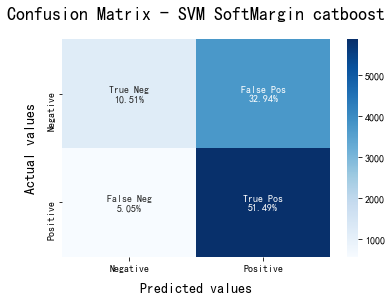

In [57]:
for model in model_list.keys():
    print("---------------------------------------\n")
    print(model)
    model_Evaluate(model_list[model], model, X_test_list[model], y_test_list[model])